# International football results from 1872 to 2017 

This dataset is provided by MartJ on [Kaggle](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017).

## Content

This dataset includes 38,361 results of international football matches starting from the very first official math in 1872 up to 2017. The matches range from World Cup to Baltic Cup to regular friendly matches. The matches are strictly men's full internationals and the data do not include Olympic Games or matches where at least one of the teams was the nation's B-team, U-23 or a league select team.

It includes the following columns:
* date: the date the match has been played;
* home_team: the team which played at home;
* away_team: the team which played away;
* home_ft: the score for the home team;
* away_ft: the score for the away team;
* tournament: friendly, world cup, copa america, etc;
* city: the city where the match has been played;
* country: the country where the match has been played.

## Acknowledgements

The data is gathered from several sources including but not limited to wikipedia.com, fifa.com, rsssf.com and individual football associations' websites.

## Code

The entire code of this analysis is on my [Github](https://github.com/StevenGolovkine/internationalFootballResults) repository.

-----

## Load the used libraries 

In [1]:
get_ipython().magic('matplotlib inline')
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

## Import the data

In [43]:
results = pd.read_csv("results.csv", sep=',', header=0)

In [3]:
# Let's look at the data
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


In [4]:
# Do the data have missing/null values?
print("There is", results.isna().sum().sum(), "missing value.")
print("There is", results.isnull().sum().sum(), "null value.")

There is 0 missing value.
There is 0 null value.


In [5]:
print("Since ", results.date[0], ", there were ", len(results), " international football matches (until ", results.date[len(results) - 1], ").", sep='')

Since 1872-11-30, there were 38685 international football matches (until 2017-11-15).


## Exploration of the data

* #### Which country played the most? 

In [6]:
count_match_home = results.home_team.value_counts()
count_match_away = results.away_team.value_counts()
count_match = pd.DataFrame([count_match_home, count_match_away]).transpose().fillna(0)
count_match['total'] = count_match.home_team + count_match.away_team
count_match = count_match.sort_values('total', ascending=False)

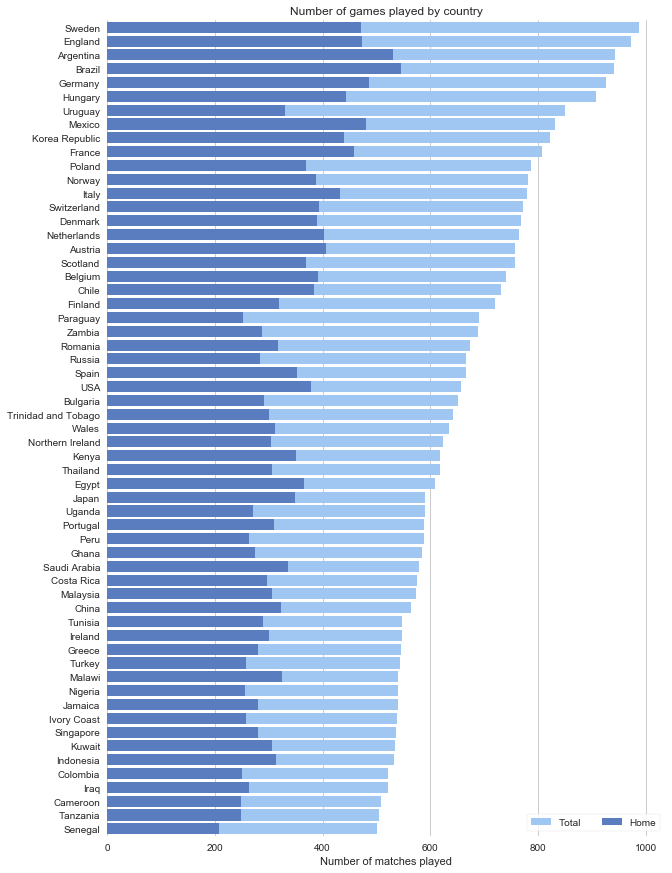

In [7]:
count_match_display = count_match[count_match.total > 500]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='total', y=count_match_display.index, data=count_match_display, label='Total', color='b')

# Plot the home match 
sns.set_color_codes("muted")
sns.barplot(x="home_team", y=count_match_display.index, data=count_match_display, label='Home', color='b')

# Add legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_title("Number of games played by country")
ax.set(xlabel="Number of matches played")
sns.despine(left=True, bottom=True)

* #### Which country won the most?

In [81]:
winner = pd.Series(np.zeros(len(results)))

for idx in results.index:
    if results.home_score.iloc[idx] > results.away_score.iloc[idx] :
        winner.iloc[idx] = results.home_team.iloc[idx]
    elif results.home_score.iloc[idx] < results.away_score.iloc[idx] :
        winner.iloc[idx] = results.away_team.iloc[idx]
    else :
        winner.iloc[idx] = None
        
count_win = pd.DataFrame(winner.value_counts(), columns=['Win'])

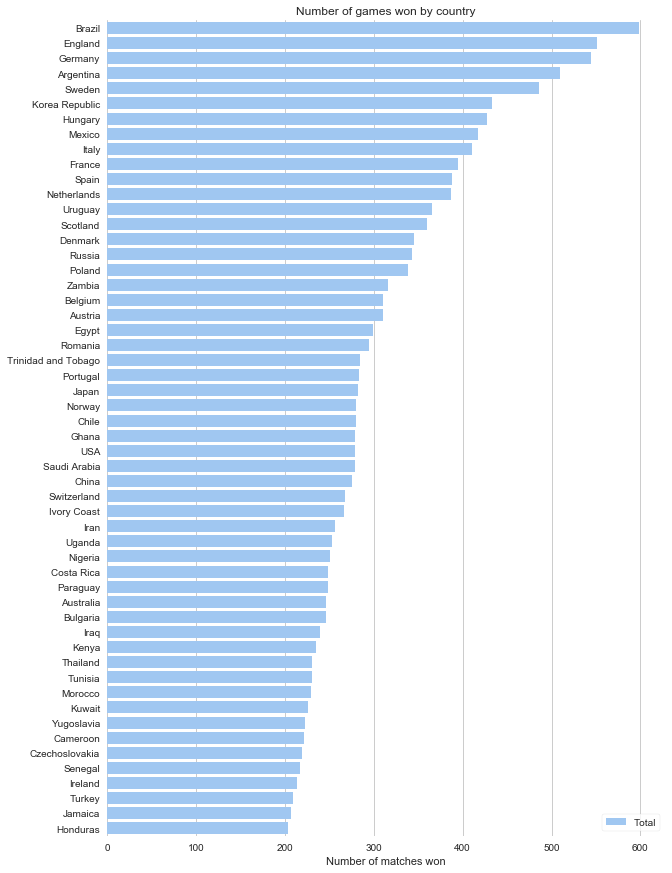

In [84]:
count_win_display = count_win[count_win > 200].dropna()

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='Win', y=count_win_display.index, data=count_win_display, label='Total', color='b')

# Add legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set_title("Number of games won by country")
ax.set(xlabel="Number of matches won")
sns.despine(left=True, bottom=True)

In [104]:
winner_percent = pd.DataFrame(count_win['Win'] / pd.DataFrame(count_match['total'])['total'], columns=['Percent'])

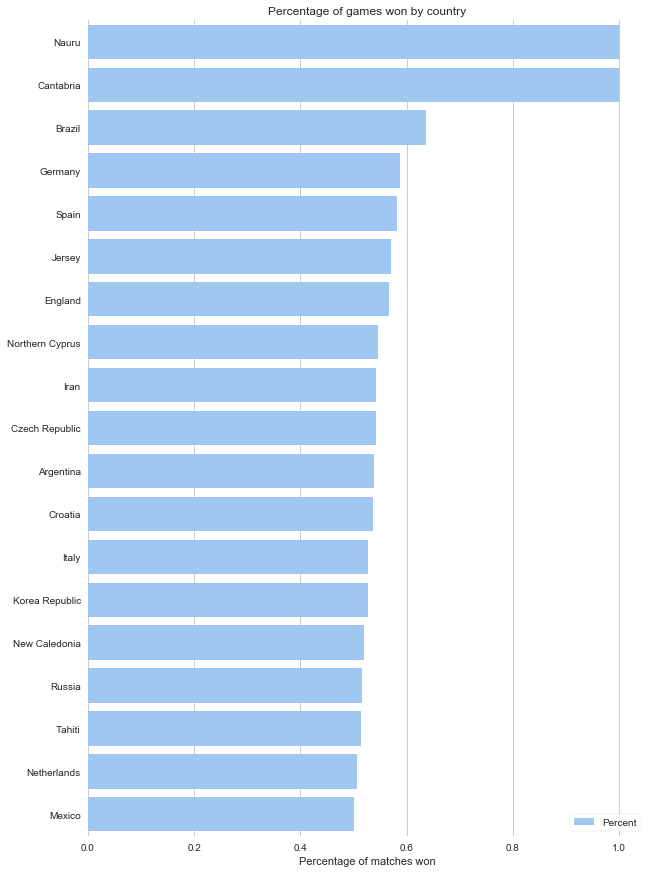

In [113]:
percent_win_display = winner_percent[winner_percent > 0.5].dropna().sort_values(by='Percent', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x='Percent', y=percent_win_display.index, data=percent_win_display, label='Percent', color='b')

# Add legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set_title("Percentage of games won by country")
ax.set(xlabel="Percentage of matches won")
sns.despine(left=True, bottom=True)

In [105]:
winner_percent

,Percent
Afghanistan,0.274510
Albania,0.246795
Algeria,0.417537
American Samoa,0.095238
Andorra,0.027586
Angola,0.342508
Anguilla,0.060000
Antigua and Barbuda,0.309392
Argentina,0.539195
Armenia,0.236842
